This notebook creates a similar plot to Fig. 17 in Merdith et al. (2017) 'A full-plate global reconstruction of the Neoproterozoic'.  I've changed it from a violin plot to a heatmap for clarity and ease of plotting.

It calculates the binned latiduinal area of continental mass and subduction zone length in 10 Ma timesteps.

It should be (reasonably) adaptable for all times, provided you have a plate model (for continental area) and plate boundaries (for subduction zones).

References

Merdith, A.S., Collins, A.S., Williams, S.E., Pisarevsky, S., Foden, J.D., Archibald, D.B., Blades, M.L., Alessio, B.L., Armistead, S., Plavsa, D., Clark, C., and Müller, R.D. 2017. A full-plate global reconstruction of the Neoproterozoic. Gondwana Research, 50, pp.84-134.

In [1]:
import pygplates
import numpy as np
import healpy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [2]:
def create_gpml_velocity_feature(longitude_array,latitude_array,filename=None,feature_type=None):
# function to make a velocity mesh nodes at an arbitrary set of points
# Long and Lat are assumed to be 1d arrays. 

    multi_point = pygplates.MultiPointOnSphere(zip(latitude_array,longitude_array))

    # Create a feature containing the multipoint feature. 
    # optionally, define as 'MeshNode' type, so that GPlates will recognise it as a velocity layer
    if feature_type=='MeshNode':
        meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
        meshnode_feature.set_name('Velocity Mesh Nodes')
    else:
        meshnode_feature = pygplates.Feature()
        meshnode_feature.set_name('Multipoint Feature')
    
    meshnode_feature.set_geometry(multi_point)
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    if filename is not None:
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

def create_gpml_healpix_mesh(nSide,filename=None,feature_type=None):

    # call the function to create a healpix array
    #nSide = 32
    othetas,ophis = healpy.pix2ang(nSide,np.arange(12*nSide**2))
    othetas = np.pi/2-othetas
    ophis[ophis>np.pi] -= np.pi*2

    lats = np.degrees(othetas) 
    lons = np.degrees(ophis)

    # call the function to create a multipoint feature, with user-defined type
    output_feature_collection = create_gpml_velocity_feature(lons,lats,filename,feature_type)

    if filename is not None:  # This is superfluous, since file has already been written in previous line???
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [3]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2017_GR/Sample_data/'
rotation_model = pygplates.RotationModel('%sMer17_1000-520Ma_rotations.rot' % basedir)
polygons = pygplates.FeatureCollection('%sMer17_1000-520Ma_shapes.gpml' % basedir)
topology_features = ['%sMer17_1000-520Ma_Convergence.gpml' % basedir,
                     '%sMer17_1000-520Ma_Divergence.gpml' % basedir,
                     '%sMer17_1000-520Ma_Topologies.gpml' % basedir,
                     '%sMer17_1000-520Ma_Transform.gpml' % basedir]

In [4]:
#set up some parameters for our analysis
#we need to know what area of the earth each point covers!

#create equal area mesh
latlon_array = []
latlon_mesh = create_gpml_healpix_mesh(32)
for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())
        
#we want to bin data into 5° latitudes
#set up bins and how much area each point covers here

#create bins
bins = np.linspace(-90,90,185/5)

#area covered by each point
number_of_points = len(latlon_array)
print 'number of points', len(latlon_array)

#surface area of the earth
r = 6371
surface_area = 4 * np.pi * r ** 2
print 'surface area of the earth', surface_area

area_per_point = surface_area/number_of_points

print 'area per point', area_per_point


number of points 12288
surface area of the earth 510064471.91
area per point 41509.1529875


In [5]:
#set time range
times=np.arange(520,1010,10)

#createsan array of lat/lons for our mesh which we use to query the amount of continental mass at each point
latlon_array = []
for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())

In [7]:
#we're going to grab subducton zone length as well as continental area
#(if you have convergence rate you could get sub area per lat)

#final results
subduction_latitude_length = []
continental_latitude_area = []

for time in times:
    #print time
    #create empty lists and arrays for storing temperorary (within a timestep) results
    tmp_sub_lat_length = np.zeros(len(bins)-1,)
    tmp_lat_points = []
    
    #reconstruct and resolve continents and plate boundaries
    reconstructed_features = []
    resolved_topologies = []
    shared_boundary_sections = []

    pygplates.reconstruct(polygons, rotation_model, reconstructed_features, time)
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    #we have to loop through the topologies
    for shared_boundary_section in shared_boundary_sections:
        #we only want subduction zones
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            #and just the segments that contribute to the topologies
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                #tessellate them to n radians so we can fit them to latitude bins
                tessellated_shared_sub_segment_polyline = (
                    shared_sub_segment.get_resolved_geometry().to_tessellated(np.radians(1)))
                
                #we want the midpoints of the segments, to see what latitude they sit in
                #and also the lengths of the arcs so we know how much is there
                tmp_arc_lat_midpoints = []
                tmp_arc_lengths = []
                
                #loop through arcs
                for arc in tessellated_shared_sub_segment_polyline.get_segments():
                    if not arc.is_zero_length():
                        tmp_arc_lengths.append(arc.get_arc_length())
                        tmp_arc_lat_midpoints.append(arc.get_arc_point(0.5).to_lat_lon_array()[:,0])
                        #we just use the mean tessellation length for ease and quickness
                        #this makes it an estimate and not an exact measure (but pretty close)
                        tessellation_length_kms = np.mean(tmp_arc_lengths) * pygplates.Earth.mean_radius_in_kms
                        #get a histogram of the data
                        tmp_sub_data = np.histogram(tmp_arc_lat_midpoints, bins)        
                        tmp_sub_length = tmp_sub_data[0] * tessellation_length_kms
                tmp_sub_lat_length += tmp_sub_length
                
    subduction_latitude_length.append(tmp_sub_lat_length)
    
    #now for continental mass, simpler code but takes longer to run (cos there's a point in polygon test)
    #we loop through our meshgrid and if a node is in a polygon we store the latitude value of that node
    #then we can make a histogram again
    for poly in reconstructed_features:
        poly_geom = poly.get_reconstructed_geometry()
        for i in latlon_array:
            if poly_geom.is_point_in_polygon(i):
                tmp_lat_points.append(i[0])
    tmp_cont_data = np.histogram(tmp_lat_points, bins)
    tmp_cont_area = tmp_cont_data[0] * area_per_point
    continental_latitude_area.append(tmp_cont_area)   

In [8]:
#turn into an array so we can plot it as a heatmap
continental_latitude_area_array = np.stack(continental_latitude_area, axis=0 )
subduction_latitude_length_array = np.stack(subduction_latitude_length, axis=0 )

#save data as a csv if you want
#np.savetxt('cont_area_vs_lat.csv', latitude_points_array, delimiter=',')

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


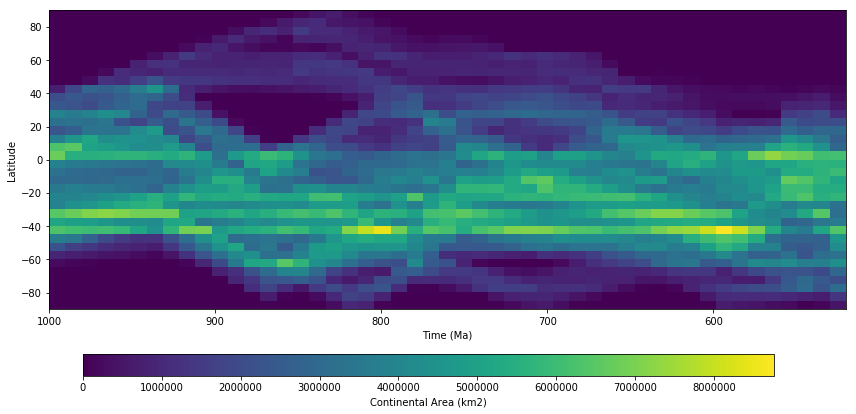

In [9]:
cm = plt.get_cmap('viridis')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6),facecolor='w', edgecolor='k')

#we have to transpose the array because it's around the wrong way
plot = ax.imshow(continental_latitude_area_array.T, origin='lower', extent=[520,1000,-90,90], cmap=cm, interpolation='None')
cax = fig.add_axes([0.1, 0, 0.8, 0.05])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
cbar.set_label('Continental Area (km2)')
ax.set_xlim(1000,520)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Latitude')
plt.tight_layout()

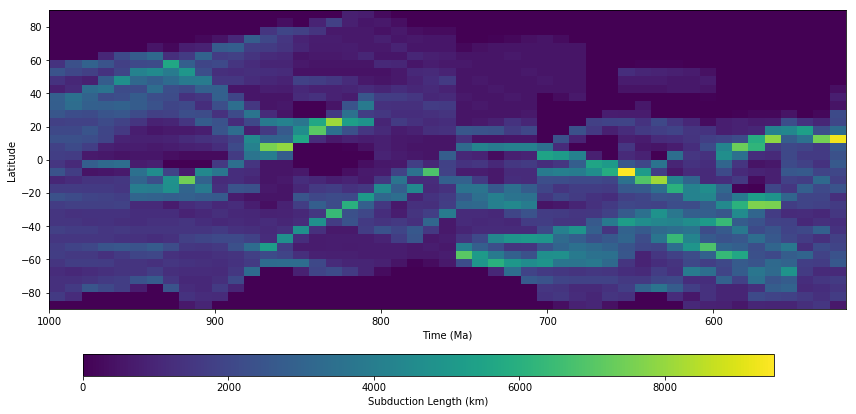

In [10]:
cm = plt.get_cmap('viridis')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6),facecolor='w', edgecolor='k')

#we have to transpose the array because it's around the wrong way
plot = ax.imshow(subduction_latitude_length_array.T, origin='lower', extent=[520,1000,-90,90], cmap=cm, interpolation='None')
cax = fig.add_axes([0.1, 0, 0.8, 0.05])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
cbar.set_label('Subduction Length (km)')
ax.set_xlim(1000,520)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Latitude')
plt.tight_layout()